# Australian Drivers Dataset Classification Model

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
plt.rcParams['figure.figsize']=(10,8)

In [2]:
# Load Data
# Source: http://www.acst.mq.edu.au/GLMsforInsuranceData
df = pd.read_csv('car.csv')

In [3]:
# Check the dimensions of the data
df.shape

(67856, 11)

In [4]:
# inspect the variables and check for incorrect data types
# veh_value stands for vehicle value, it is in $10,000s
# exposure is percentage of units actually exposed to loss at a given point in time
# clm stands for occurrence of claim (0 = no, 1 = yes)
# numclaims stands for number of claims
# claimcst0 stands for claim amount (0 if no claim)
# veh_body stands for vehiclebody type
# veh_age stands for vehicle age and it ranges from 1 (youngest), 2, 3, 4
# gender is a factor with levels F (female) M (male)
# area is a factor with levels A B C D E F
# agecat stands for age category and it ranges from 1 (youngest), 2, 3, 4, 5, 6
# X_OBSTAT_ a factor with levels 01101. This is a constant variable.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 11 columns):
veh_value    67856 non-null float64
exposure     67856 non-null float64
clm          67856 non-null int64
numclaims    67856 non-null int64
claimcst0    67856 non-null float64
veh_body     67856 non-null object
veh_age      67856 non-null int64
gender       67856 non-null object
area         67856 non-null object
agecat       67856 non-null int64
_OBSTAT_     67856 non-null object
dtypes: float64(3), int64(4), object(4)
memory usage: 5.7+ MB


In [5]:
# Check for missing values. There are no missing data.
df[df.isnull()].sum()

veh_value    0.0
exposure     0.0
clm          0.0
numclaims    0.0
claimcst0    0.0
veh_body     0.0
veh_age      0.0
gender       0.0
area         0.0
agecat       0.0
_OBSTAT_     0.0
dtype: float64

In [6]:
# This is another way to check for missing data.
df.isnull().any()

veh_value    False
exposure     False
clm          False
numclaims    False
claimcst0    False
veh_body     False
veh_age      False
gender       False
area         False
agecat       False
_OBSTAT_     False
dtype: bool

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
veh_value,67856.0,1.777021,1.205232,0.000000,1.010000,1.50000,2.150000,34.560000
exposure,67856.0,0.468652,0.290025,0.002738,0.219028,0.44627,0.709103,0.999316
clm,67856.0,0.068144,0.251995,0.000000,0.000000,0.00000,0.000000,1.000000
numclaims,67856.0,0.072757,0.278204,0.000000,0.000000,0.00000,0.000000,4.000000
claimcst0,67856.0,137.270167,1056.297768,0.000000,0.000000,0.00000,0.000000,55922.129883
veh_age,67856.0,2.673529,1.067542,1.000000,2.000000,3.00000,4.000000,4.000000
agecat,67856.0,3.485484,1.425608,1.000000,2.000000,3.00000,5.000000,6.000000


In [8]:
# Distribution of number of claims
df.numclaims.value_counts()

0    63232
1     4333
2      271
3       18
4        2
Name: numclaims, dtype: int64

In [9]:
# Below is a ratio or a percentage of claims over the total
df.clm.value_counts()[1]/(df.clm.value_counts()[0]+df.clm.value_counts()[1])

0.06814430558830464

The postive class accounts for: 6.814% of the entire claims filed


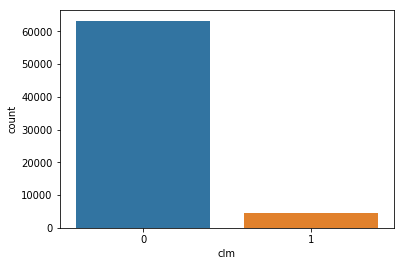

In [10]:
# Distribution of the response variable clm, from inspection we can see that there is class imbalance.
sns.countplot(x='clm',data=df)

print('The postive class accounts for: %s'% '{:.3%} of the entire claims filed'
      .format(df.clm.value_counts()[1]/(df.clm.value_counts()[0]+df.clm.value_counts()[1])))

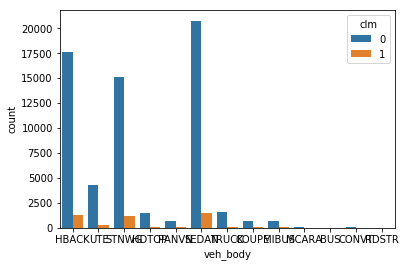

In [11]:
# Which vehicle types accounted for most of the claims filed?
ax1 = sns.countplot(x="veh_body", data=df,hue='clm')

In [12]:
# of those that filed claims how many were they distributed across veh_body
vehicle_type = df[df['clm']==1].groupby('veh_body')['clm'].sum()
vehicle_type = pd.DataFrame(vehicle_type).reset_index()

# Percentage calculation (long approach)
percent = []
for i in range (0,len(vehicle_type)):
        vehicle_percent = round(100*(vehicle_type['clm'].ix[i]/vehicle_type['clm'].sum()),2) # iterate over clm column
        percent.append(vehicle_percent)
vehicle_type['Percent %'] = pd.DataFrame(percent)
vehicle_type

/Users/jongyeoblee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,veh_body,clm,Percent %
0,BUS,9,0.19
1,CONVT,3,0.06
2,COUPE,68,1.47
3,HBACK,1264,27.34
4,HDTOP,130,2.81
5,MCARA,14,0.30
6,MIBUS,43,0.93
7,PANVN,62,1.34
8,RDSTR,2,0.04
9,SEDAN,1476,31.92


In [13]:
# Option 2 - Calcuating percentage the short way
vehicle_type['Percentage (short)'] = round((vehicle_type['clm']/vehicle_type['clm'].sum())*100,2)
# then drop the variable percent that was created from the previous run
short_approach = vehicle_type.drop('Percent %',axis=1)
short_approach

,veh_body,clm,Percentage (short)
0,BUS,9,0.19
1,CONVT,3,0.06
2,COUPE,68,1.47
3,HBACK,1264,27.34
4,HDTOP,130,2.81
5,MCARA,14,0.30
6,MIBUS,43,0.93
7,PANVN,62,1.34
8,RDSTR,2,0.04
9,SEDAN,1476,31.92


/Users/jongyeoblee/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/jongyeoblee/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/jongyeoblee/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


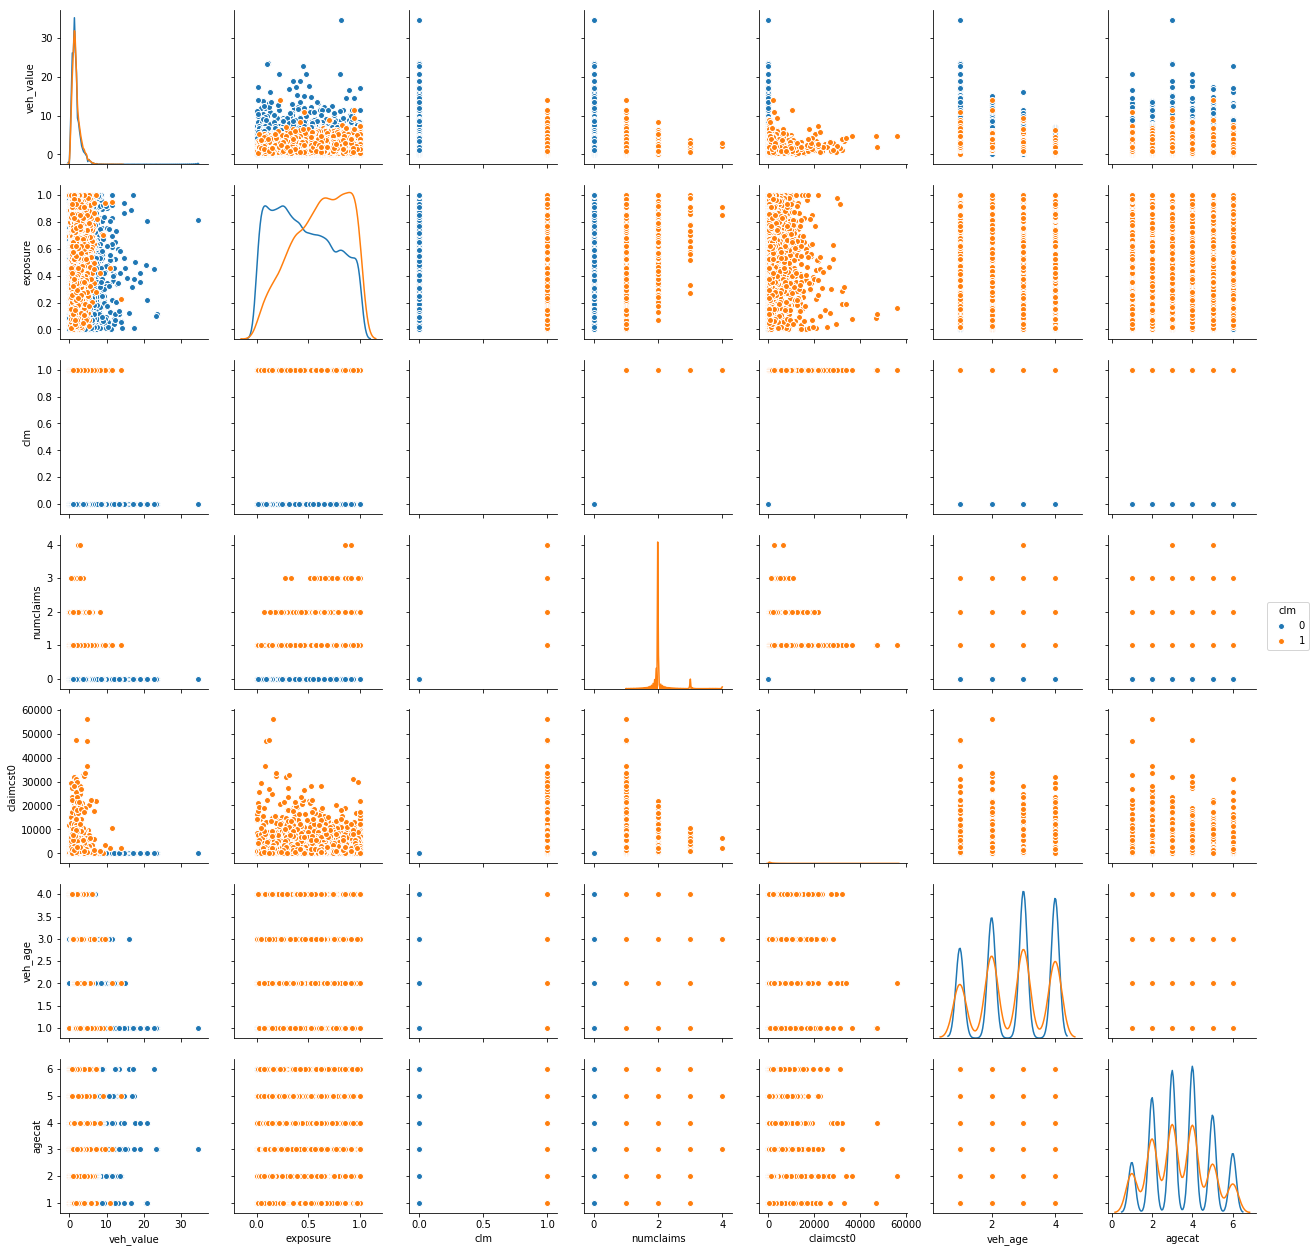

In [14]:
# Are any of the features correlated with each other?
# use a pairplot and for the diag_kind you have the option of hist or kde
sns.pairplot(df,diag_kind='kde',hue='clm')

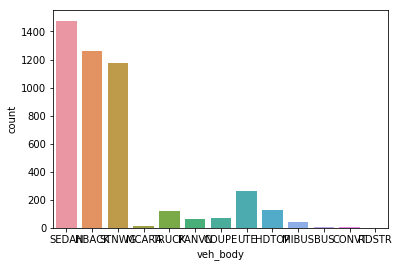

In [15]:
# Which vehicles types filed the most claims
claims_filed = df[df['clm']==1]
sns.countplot('veh_body',data=claims_filed)

In [16]:
# While we cannot use gender as a feature, we can see if there is a difference between claims filed by males and females
df[df['clm']==1].groupby('gender')['clm'].count()

gender
F    2648
M    1976
Name: clm, dtype: int64

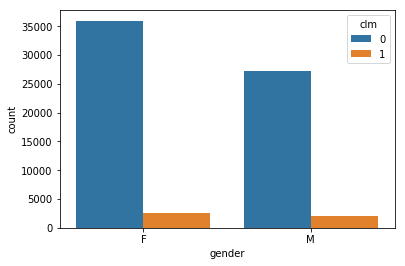

In [17]:
# Distributtion of claims filed between men vs women
sns.countplot(x='gender',data=df,hue='clm')

In [18]:
# Are younger drivers more likely to get into an acident?
df['agecat'].value_counts()  # This is the breakdown of drive age category ( 1= youngest)

4    16189
3    15767
2    12875
5    10736
6     6547
1     5742
Name: agecat, dtype: int64

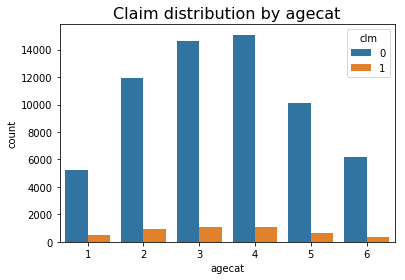

In [19]:
# Claim distribution by agecat
sns.countplot(data=df,x='agecat',hue='clm')
_=plt.title('Claim distribution by agecat',fontsize=16)

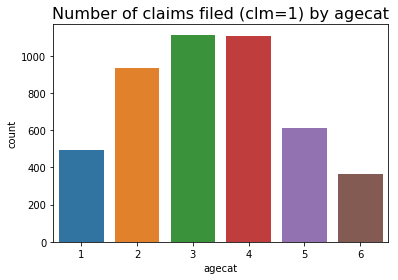

In [20]:
# Seems like middle aged (age cat 2-4) drivers are responsible for most of the claims filed
sns.countplot(data=df[df['clm']==1],x='agecat')
_=plt.title('Number of claims filed (clm=1) by agecat',fontsize=16)

In [21]:
# Ratio of claim count by age as a percentage
scaled = df[df['clm']==1].groupby('agecat')['clm'].count()/df[df['clm']>=0].groupby('agecat')['clm'].count()
scaled*100

agecat
1    8.638105
2    7.238835
3    7.059047
4    6.819445
5    5.719076
6    5.575073
Name: clm, dtype: float64

In [22]:
# Convert to a dataframe
scaled = pd.DataFrame(scaled).reset_index()

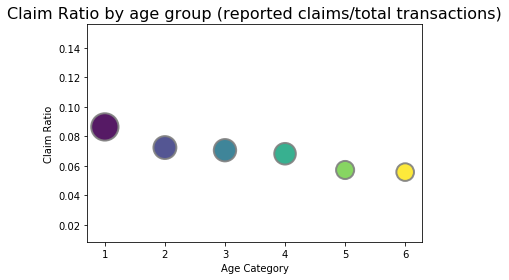

In [23]:
# Bubble plot of the Claim ratio
# Use the option s: scalar or array_like size in points^2
# Use the option c: for sequence of color
x = scaled['agecat']
y = scaled['clm']
axes = plt.scatter(x, y,c=scaled['agecat'], s=(y**2)*100000, cmap="viridis", alpha=0.9, edgecolors="grey", linewidth=2)
_=plt.title('Claim Ratio by age group (reported claims/total transactions)',fontsize=16)
_=plt.xlabel('Age Category')
_=plt.ylabel('Claim Ratio')

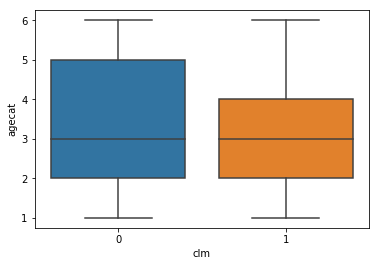

In [24]:
# Are there any outliers when it comes to comparing exposure with claims. There are no outliers. 
_=sns.boxplot(x='clm',y='agecat',data=df)

Text(0.5,1,' Pearson R Correlation Plot')

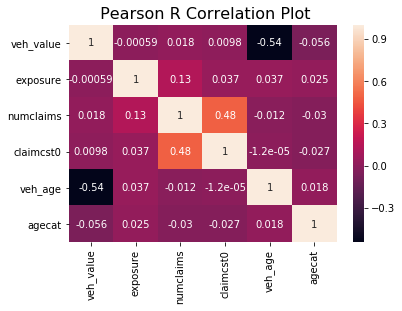

In [25]:
# What are the correlation values between variables
sns.heatmap(df.drop('clm',axis=1).corr(),annot=True)  # remove the response variable before comparing 
plt.title(' Pearson R Correlation Plot',fontsize=16)

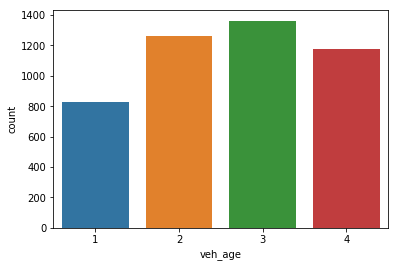

In [26]:
# Are older or newer vehicles more likeley to file a claim?
# Remember we already defined above: claims_filed = df[df['clm']==1]
sns.countplot(x='veh_age',data=claims_filed)

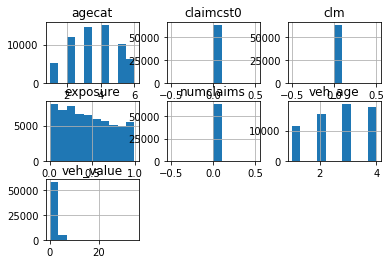

In [27]:
# How are the variables distributed for policies holders who did not file claims?
claims= df[df['clm']==0]
_=claims.hist()

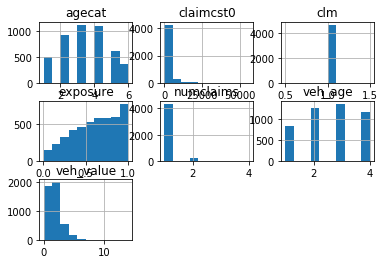

In [28]:
# Distribution of variables for policy holders that filed a claim
claims= df[df['clm']==1]
_=claims.hist()
# or you can run this _=df.hist(bins=10,grid=False)

## Investigating variable distribution

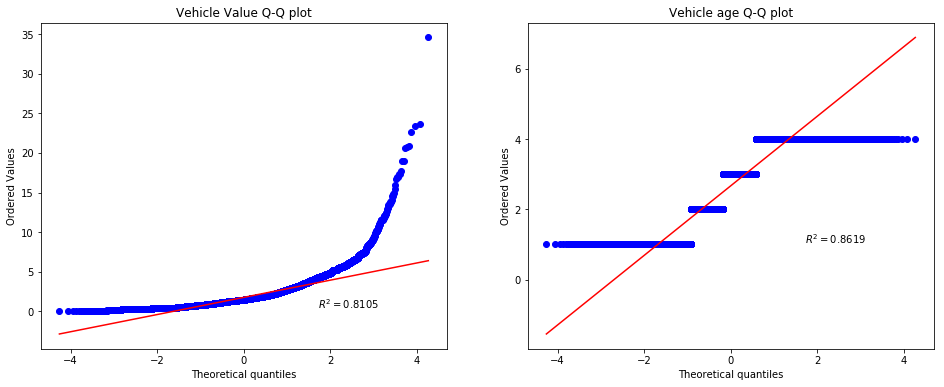

In [29]:
# Can we assume that these variables are from the normal distribution(continusous variables only)?
# Here we can see that vehicle value is skewed to the left
plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
ax1 = stats.probplot(df['veh_value'],plot=pylab,rvalue=True)
pylab.title('Vehicle Value Q-Q plot')

ax2 = plt.subplot(122)
stats.probplot(df['veh_age'],plot=pylab,rvalue=True)
pylab.title('Vehicle age Q-Q plot')

pylab.show()

In [30]:
# Calculate skewness of each variable. Skewness is a measure of the asymmetry of the probability distribution 
# of a real-valued random variable about its mean
df.skew(axis=0)

veh_value     2.968022
exposure      0.175557
clm           3.427592
numclaims     4.067377
claimcst0    17.502503
veh_age      -0.213143
agecat        0.058077
dtype: float64

In [31]:
import warnings
warnings.filterwarnings("ignore") # disable deprecation warnings

# Try scaling using log(x), (x-x_min)/(max-min), and z-score approach
df_new = df[df['veh_value']>0]   # prevents the log from producing values with -inf (infinity)
df_veh_value = df_new[['veh_value']]

# Normalized between 0 and 1:(x - min)/(max - min)
df_veh_value['Normalized']= ((df_veh_value['veh_value']-min(df_veh_value['veh_value']))/
                         (max(df_veh_value['veh_value'])-min(df_veh_value['veh_value'])))

# Log Transformed
df_veh_value['Log transform'] = df_veh_value[['veh_value']].applymap(lambda x: np.log(x))

# z-score standarization based on (x - mean)/(standard deviation)
df_veh_value['z-score'] = df_veh_value[['veh_value']].applymap(lambda x: (x-np.mean(df['veh_value']))/
                                                               np.std(df['veh_value']))

df_veh_value.head()


,veh_value,Normalized,Log transform,z-score
0,1.06,0.025596,0.058269,-0.594928
1,1.03,0.024724,0.029559,-0.619820
2,3.26,0.089587,1.181727,1.230461
3,4.14,0.115183,1.420696,1.960616
4,0.72,0.015707,-0.328504,-0.877033


In [32]:
# Original df has several 0 veh_value observations
df[df['veh_value']==0].count()['veh_value']

53

In [33]:
# This another way to see number of times 0 appears
df[df['veh_value']==0].shape[0]

53

In [34]:
# Log transformations can create infinite numbers if you have negative numbers or zero. 
# After checking the newly defined array df_veh_value there is no entries equal to infinity
np.isinf(df_veh_value).sum()

veh_value        0
Normalized       0
Log transform    0
z-score          0
dtype: int64

In [35]:
# Check for NAN values. There is no null values.
pd.isnull(df_veh_value).sum()

veh_value        0
Normalized       0
Log transform    0
z-score          0
dtype: int64

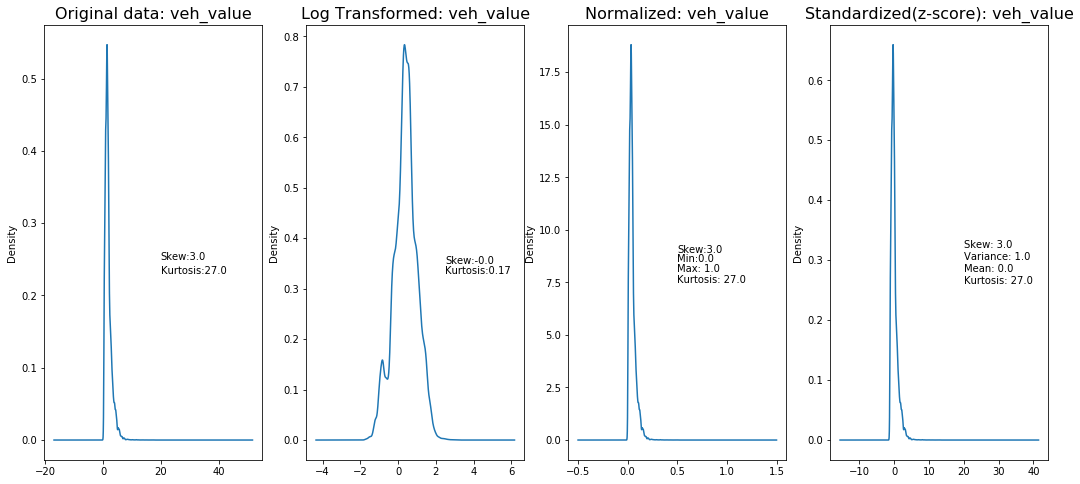

In [36]:
# Plots of the scaled data
# Kurtosis the sharpness of the peak of a frequency-distribution curve
# Skewness is a measure of the asymmetry of the probability distr of a real-valued random variable about its mean
plt.figure(figsize=(18,8))

# Original data
ax1 = plt.subplot(141)
df_veh_value['veh_value'].plot(kind='density')
plt.title('Original data: veh_value',fontsize =16)
plt.text(20,.25,'Skew:{}'.format(round(df_veh_value['veh_value'].skew(),0)))
plt.text(20,.23,'Kurtosis:{}'.format(round(df_veh_value['veh_value'].kurtosis(),0)))

# Log transformed
ax2 = plt.subplot(142)
df_veh_value['Log transform'].plot(kind='density')
plt.title('Log Transformed: veh_value',fontsize =16)
plt.text(2.5,.35,'Skew:{}'.format(round(df_veh_value['Log transform'].skew(),0)))
plt.text(2.5,.33,'Kurtosis:{}'.format(round(df_veh_value['Log transform'].kurtosis(),2)))


# Normalized
ax3 = plt.subplot(143)
df_veh_value['Normalized'].plot(kind='density')
plt.title('Normalized: veh_value',fontsize =16)
plt.text(0.5,8.9,'Skew:{}'.format(round(df_veh_value['Normalized'].skew(),0)))
plt.text(0.5,8.5,'Min:{}'.format(round(np.min(df_veh_value['Normalized']),0)))
plt.text(0.5,8.0,'Max: {}'.format(round(np.max(df_veh_value['Normalized']),0)))
plt.text(0.5,7.5,'Kurtosis: {}'.format(round(df_veh_value['Normalized'].kurtosis(),0)))

# z-score scaling
ax4 = plt.subplot(144)
df_veh_value['z-score'].plot(kind='density')
plt.title('Standardized(z-score): veh_value',fontsize =16)
plt.text(20,0.32,'Skew: {}'.format(round(df_veh_value['z-score'].skew(),0)))
plt.text(20,0.3,'Variance: {}'.format(round(np.var(df_veh_value['z-score']),0)))
_=plt.text(20,0.28,'Mean: {}'.format(round(np.mean(df_veh_value['z-score']),0))) # included the _= here because only the last item tag gets returned
_=plt.text(20,0.26,'Kurtosis: {}'.format(round(df_veh_value['z-score'].kurtosis(),0)))

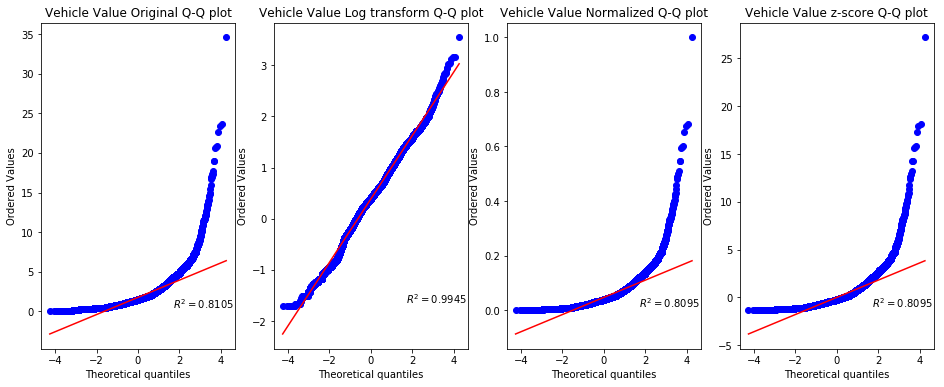

In [37]:
# What does the  distribution of the veh_value variable look like after transformation? 

plt.figure(figsize=(16,6))
plt.subplot(141)
stats.probplot(df['veh_value'],plot=pylab,rvalue=True)
pylab.title('Vehicle Value Original Q-Q plot')

plt.subplot(142)
stats.probplot(df_veh_value['Log transform'],plot=pylab,rvalue=True)
pylab.title('Vehicle Value Log transform Q-Q plot')

plt.subplot(143)
stats.probplot(df_veh_value['Normalized'],plot=pylab,rvalue=True)
pylab.title('Vehicle Value Normalized Q-Q plot')

plt.subplot(144)
stats.probplot(df_veh_value['z-score'],plot=pylab,rvalue=True)
_=pylab.title('Vehicle Value z-score Q-Q plot')


# pylab.show()

# Model

In [38]:
# Import Python's Machine Learning packages from sklearn
from sklearn.cross_validation import KFold,StratifiedKFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,auc,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_confusion_matrix  
# You need to install the package mlxtend for the confusion matrix, run this is in seperate cell: !pip install mlxtend

/Users/jongyeoblee/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Label encode 'area'

In [39]:
# Label encode(dummy) text variables. The table shows how the variables were encoded in the columns veh_body and area
# Use the labelencoder to convert string variables into numeric variables
label_encode = LabelEncoder()
df['veh_body_encode'] = label_encode.fit_transform(df['veh_body'])
df['area_encode'] = label_encode.fit_transform(df['area'])
df[['veh_body','veh_body_encode','area','area_encode']].head()

,veh_body,veh_body_encode,area,area_encode
0,HBACK,3,C,2
1,HBACK,3,A,0
2,UTE,12,E,4
3,STNWG,10,D,3
4,HBACK,3,C,2


In [40]:
# Drop gender because it is not permitted. Drop OBSTAT variable because it is a labeling costant.
# Drop and claim indication numclaims and claimcost because it is highly correlated with claims.
# Drop veh_body and area since we encoded them and we do not need them anymore
# Drop exposure because it is hard to explain and implement
# Finally drop clm from the X array because that is the dependent variable and it belongs to y
X = df.drop(['gender','_OBSTAT_','veh_body','area','numclaims', 'claimcst0','exposure', 'clm'],axis=1)
y = df['clm']

In [41]:
X.head()

,veh_value,veh_age,agecat,veh_body_encode,area_encode
0,1.06,3,2,3,2
1,1.03,2,4,3,0
2,3.26,2,2,12,4
3,4.14,2,2,10,3
4,0.72,4,2,3,2


In [42]:
# Alternative array approach to encoding
# X.iloc[:,4]=label_encode.fit_transform(X.iloc[:,4]) # encode veh_body
# X.iloc[:,6]=label_encode.fit_transform(X.iloc[:,6]) # encode area
# onehotencode = OneHotEncoder(categorical_features=[4,6])
# X = onehotencode.fit_transform(X).toarray() # onehotencode removes any assumption of order i.e 1<2<3<4 etc. after encoding variable

### Train/Test Split

In [43]:
# Split the data into training and testing data set. Test contains 30% of the data and Train contains 70% of the data.
# Add the option random_state to preserve the random generated training and testing set so that it is the same on each run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Scale Data

In [44]:
# Standardization of a dataset is a common requirement for many machine learning estimators
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

## Random Forest

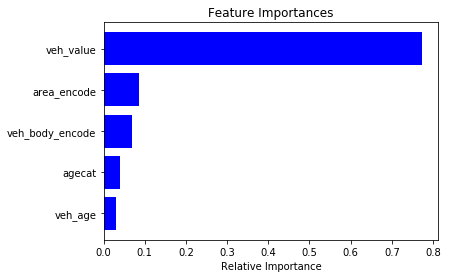

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

# Plot of Feature Importances
features = X.columns
importances = rf.feature_importances_ 
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
_=plt.xlabel('Relative Importance')

# Baseline Model 1 : Logistic Regression

In [46]:
# Redefine X. Drop veh_age since it is not as important. Keep the 4 most important variables to make the model simple
X_new= X[['area_encode','veh_body_encode', 'agecat', 'veh_value']]

In [47]:
# Train test split the new data set that contains the four most important variables
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [48]:
log_reg = LogisticRegression()
log_reg.fit(X_train_new,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
# Predict on test set
predictions_new = log_reg.predict(X_test_new)

# 10-fold Cross Validation
accuracies_cv_new = cross_val_score(estimator= log_reg,X= X_train_new,y=y_train,cv=10)

The 10-fold cross validation accuracy of this model is: 93.143%
The accuracy of this model is: 93.285%


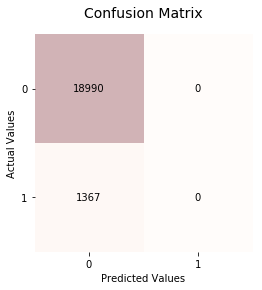

In [50]:
 # Create confusion matrix plot
cm = confusion_matrix(y_test,predictions_new)
fig = plot_confusion_matrix(conf_mat=cm,figsize=(4,4),cmap=plt.cm.Reds,hide_spines=True)
plt.title('Confusion Matrix',fontsize=14)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
# Turn the axis grid off
plt.grid('off')

# Print out metrics
print('The 10-fold cross validation accuracy of this model is: %s' % '{0:.3%}'.format(accuracies_cv_new.mean()))
print('The accuracy of this model is: %s' % '{0:.3%}'.format(accuracy_score(y_test,predictions_new)))

# Baseline Model 2 : Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

In [52]:
# Decision tree on over sampled minority class data
dt = DecisionTreeClassifier()
dt.fit(X_train_new,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [53]:
# Predict on test set
predictions_new_dt = dt.predict(X_test_new)

# 10-fold Cross Validation
accuracies_cv_new_dt = cross_val_score(estimator= log_reg,X= X_train_new,y=y_train,cv=10)

The 10-fold cross validation accuracy of this model is: 93.143%
The accuracy of this model is: 90.421%


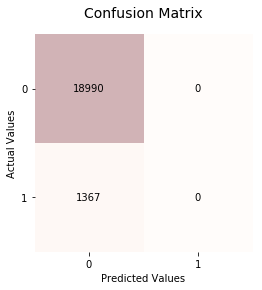

In [54]:
 # Create confusion matrix plot
cm = confusion_matrix(y_test,predictions_new)
fig = plot_confusion_matrix(conf_mat=cm,figsize=(4,4),cmap=plt.cm.Reds,hide_spines=True)
plt.title('Confusion Matrix',fontsize=14)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
# Turn the axis grid off
plt.grid('off')

# Print out metrics
print('The 10-fold cross validation accuracy of this model is: %s' % '{0:.3%}'.format(accuracies_cv_new_dt.mean()))
print('The accuracy of this model is: %s' % '{0:.3%}'.format(accuracy_score(y_test,predictions_new_dt)))

# Explanation:
While the Decision Tree Classifier performed marginally better, we can see that it only predicted 4.6% of the positive or minority class correctly and misclassified only 3% of the of the negative or majority class.However, given the imbalanced nature of the data set the model is biased to the postive class. To address this problem there are many over-sampling and under-sampling techniques used to balance the dataset and prevent expert bias. 

In [55]:
# First install the package imblearn by running this code is a seprate cell !pip install imblearn
from imblearn.over_sampling import SMOTE
# Use Ratio=1 for resampling the data set (one to one ratio).
# Use the random_state option to preserve the randomness on each run
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train_new, y_train)

/Users/jongyeoblee/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


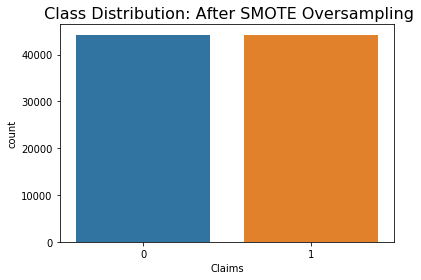

In [56]:
# Class distribution after SMOTE  
resampled = pd.DataFrame(y_train_res)
sns.countplot(x=0,data=resampled)
plt.title(' Class Distribution: After SMOTE Oversampling',fontsize = 16)
_=plt.xlabel('Claims')

# Logistic Regression after SMOTE 

In [57]:
# Logistic Regression on over sampled minority class data
log_reg.fit(x_train_res,y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
# Predict on test set
predictions_res = log_reg.predict(X_test_new)

# 10-fold Cross Validation
accuracies_cv_res = cross_val_score(estimator= log_reg,X= x_train_res,y=y_train_res,cv=10)

The 10-fold cross validation accuracy of this model is: 53.466%
The accuracy of this model is: 53.480%


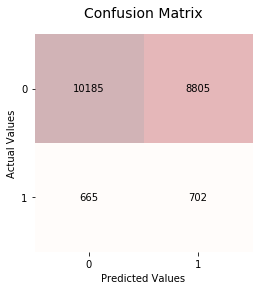

In [59]:
 # Create confusion matrix plot
cm = confusion_matrix(y_test,predictions_res)
fig= plot_confusion_matrix(conf_mat=cm,figsize=(4,4),cmap=plt.cm.Reds,hide_spines=True)
plt.title('Confusion Matrix',fontsize=14)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid('off')

# Print out metrics
print('The 10-fold cross validation accuracy of this model is: %s' % '{0:.3%}'.format(accuracies_cv_res.mean()))
print('The accuracy of this model is: %s' % '{0:.3%}'.format(accuracy_score(y_test,predictions_res)))

# Decision Tree after SMOTE

In [60]:
dt.fit(x_train_res,y_train_res)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [61]:
# Predict on test set
predictions_res_dt = dt.predict(X_test_new)

# 10-fold Cross Validation
accuracies_cv_res_dt = cross_val_score(estimator= dt,X= x_train_res,y=y_train_res,cv=10)

The 10-fold cross validation accuracy of this model is: 83.496%
The accuracy of this model is: 83.495%


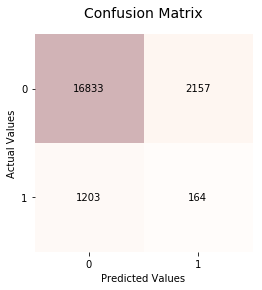

In [63]:
# Create confusion matrix plot
cm = confusion_matrix(y_test,predictions_res_dt)
fig= plot_confusion_matrix(conf_mat=cm,figsize=(4,4),cmap=plt.cm.Reds,hide_spines=True)
plt.title('Confusion Matrix',fontsize=14)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid('off')

# Print out metrics
print('The 10-fold cross validation accuracy of this model is: %s' % '{0:.3%}'.format(accuracies_cv_res_dt.mean()))
print('The accuracy of this model is: %s' % '{0:.3%}'.format(accuracy_score(y_test,predictions_res_dt)))